# **Homework 12 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [24]:
#!apt update
#!apt install python-opengl xvfb -y
!pip install pyopengl xvfbwrapper
!pip install 'gym[box2d]==0.18.3' pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


接下來，設置好 virtual display，並引入所有必要的套件。

In [25]:
%%capture
from pyvirtualdisplay import Display
#virtual_display = Display(visible=0, size=(1400, 900))
#virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# 請不要更改 random seed !!!!
# 不然在judgeboi上 你的成績不會被reproduce !!!!

In [26]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [27]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')

fix(env, seed)

[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())


In [28]:
import time
start = time.time()

In [29]:
!pip freeze

addict==2.4.0
antlr4-python3-runtime==4.8
appnope @ file:///opt/concourse/worker/volumes/live/4f734db2-9ca8-4d8b-5b29-6ca15b4b4772/volume/appnope_1606859466979/work
argcomplete @ file:///tmp/build/80754af9/argcomplete_1618920853202/work
argon2-cffi @ file:///opt/concourse/worker/volumes/live/4afd07c8-7fc3-4a09-6326-d8c70269eb33/volume/argon2-cffi_1613037490059/work
async-generator==1.10
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4==4.10.0
bleach @ file:///tmp/build/80754af9/bleach_1628110601003/work
box2d-py==2.3.8
certifi==2021.10.8
cffi @ file:///opt/concourse/worker/volumes/live/4a8f7628-1917-402a-5a6a-cdafcc3ec547/volume/cffi_1625814707380/work
charset-normalizer==2.0.11
click==8.0.3
cloudpickle==1.6.0
colorama==0.4.4
cycler==0.11.0
Cython==0.29.27
debugpy @ file:///opt/concourse/worker/volumes/live/32b11d06-4d64-4ec8-497a-cf4fc97343d2/volume/debugpy_1637091821874/work
decorator @ file:/

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [30]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [31]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [32]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [33]:
random_action = env.action_space.sample()
print(random_action)

0


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [34]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [35]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.


In [36]:
print(reward) # after doing a random action (0), the immediate reward is stored in this 

-0.8588900517154912


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

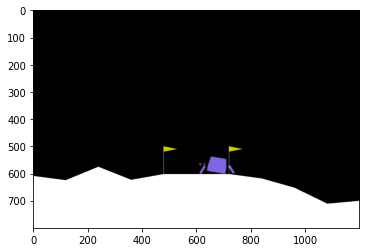

In [37]:

env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [38]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [39]:

class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
         
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])


最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [40]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
#agent = PolicyGradientAgent()

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [41]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at , log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    print(f"rewards looks like ", np.shape(rewards))  
    print(f"log_probs looks like ", np.shape(log_probs))     
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

  0%|          | 0/400 [00:00<?, ?it/s]

rewards looks like  (448,)
log_probs looks like  (448,)
logs prob looks like  torch.Size([448])
torch.from_numpy(rewards) looks like  torch.Size([448])
rewards looks like  (515,)
log_probs looks like  (515,)
logs prob looks like  torch.Size([515])
torch.from_numpy(rewards) looks like  torch.Size([515])
rewards looks like  (392,)
log_probs looks like  (392,)
logs prob looks like  torch.Size([392])
torch.from_numpy(rewards) looks like  torch.Size([392])
rewards looks like  (518,)
log_probs looks like  (518,)
logs prob looks like  torch.Size([518])
torch.from_numpy(rewards) looks like  torch.Size([518])
rewards looks like  (472,)
log_probs looks like  (472,)
logs prob looks like  torch.Size([472])
torch.from_numpy(rewards) looks like  torch.Size([472])
rewards looks like  (530,)
log_probs looks like  (530,)
logs prob looks like  torch.Size([530])
torch.from_numpy(rewards) looks like  torch.Size([530])
rewards looks like  (463,)
log_probs looks like  (463,)
logs prob looks like  torch.Size

rewards looks like  (533,)
log_probs looks like  (533,)
logs prob looks like  torch.Size([533])
torch.from_numpy(rewards) looks like  torch.Size([533])
rewards looks like  (529,)
log_probs looks like  (529,)
logs prob looks like  torch.Size([529])
torch.from_numpy(rewards) looks like  torch.Size([529])
rewards looks like  (635,)
log_probs looks like  (635,)
logs prob looks like  torch.Size([635])
torch.from_numpy(rewards) looks like  torch.Size([635])
rewards looks like  (555,)
log_probs looks like  (555,)
logs prob looks like  torch.Size([555])
torch.from_numpy(rewards) looks like  torch.Size([555])
rewards looks like  (662,)
log_probs looks like  (662,)
logs prob looks like  torch.Size([662])
torch.from_numpy(rewards) looks like  torch.Size([662])
rewards looks like  (500,)
log_probs looks like  (500,)
logs prob looks like  torch.Size([500])
torch.from_numpy(rewards) looks like  torch.Size([500])
rewards looks like  (484,)
log_probs looks like  (484,)
logs prob looks like  torch.Size

rewards looks like  (1187,)
log_probs looks like  (1187,)
logs prob looks like  torch.Size([1187])
torch.from_numpy(rewards) looks like  torch.Size([1187])
rewards looks like  (846,)
log_probs looks like  (846,)
logs prob looks like  torch.Size([846])
torch.from_numpy(rewards) looks like  torch.Size([846])
rewards looks like  (830,)
log_probs looks like  (830,)
logs prob looks like  torch.Size([830])
torch.from_numpy(rewards) looks like  torch.Size([830])
rewards looks like  (722,)
log_probs looks like  (722,)
logs prob looks like  torch.Size([722])
torch.from_numpy(rewards) looks like  torch.Size([722])
rewards looks like  (733,)
log_probs looks like  (733,)
logs prob looks like  torch.Size([733])
torch.from_numpy(rewards) looks like  torch.Size([733])
rewards looks like  (1109,)
log_probs looks like  (1109,)
logs prob looks like  torch.Size([1109])
torch.from_numpy(rewards) looks like  torch.Size([1109])
rewards looks like  (914,)
log_probs looks like  (914,)
logs prob looks like  to

logs prob looks like  torch.Size([1736])
torch.from_numpy(rewards) looks like  torch.Size([1736])
rewards looks like  (667,)
log_probs looks like  (667,)
logs prob looks like  torch.Size([667])
torch.from_numpy(rewards) looks like  torch.Size([667])
rewards looks like  (1041,)
log_probs looks like  (1041,)
logs prob looks like  torch.Size([1041])
torch.from_numpy(rewards) looks like  torch.Size([1041])
rewards looks like  (871,)
log_probs looks like  (871,)
logs prob looks like  torch.Size([871])
torch.from_numpy(rewards) looks like  torch.Size([871])
rewards looks like  (1023,)
log_probs looks like  (1023,)
logs prob looks like  torch.Size([1023])
torch.from_numpy(rewards) looks like  torch.Size([1023])
rewards looks like  (1076,)
log_probs looks like  (1076,)
logs prob looks like  torch.Size([1076])
torch.from_numpy(rewards) looks like  torch.Size([1076])
rewards looks like  (1666,)
log_probs looks like  (1666,)
logs prob looks like  torch.Size([1666])
torch.from_numpy(rewards) looks

rewards looks like  (414,)
log_probs looks like  (414,)
logs prob looks like  torch.Size([414])
torch.from_numpy(rewards) looks like  torch.Size([414])
rewards looks like  (459,)
log_probs looks like  (459,)
logs prob looks like  torch.Size([459])
torch.from_numpy(rewards) looks like  torch.Size([459])
rewards looks like  (441,)
log_probs looks like  (441,)
logs prob looks like  torch.Size([441])
torch.from_numpy(rewards) looks like  torch.Size([441])
rewards looks like  (566,)
log_probs looks like  (566,)
logs prob looks like  torch.Size([566])
torch.from_numpy(rewards) looks like  torch.Size([566])
rewards looks like  (486,)
log_probs looks like  (486,)
logs prob looks like  torch.Size([486])
torch.from_numpy(rewards) looks like  torch.Size([486])
rewards looks like  (515,)
log_probs looks like  (515,)
logs prob looks like  torch.Size([515])
torch.from_numpy(rewards) looks like  torch.Size([515])
rewards looks like  (420,)
log_probs looks like  (420,)
logs prob looks like  torch.Size

logs prob looks like  torch.Size([2093])
torch.from_numpy(rewards) looks like  torch.Size([2093])
rewards looks like  (1098,)
log_probs looks like  (1098,)
logs prob looks like  torch.Size([1098])
torch.from_numpy(rewards) looks like  torch.Size([1098])
rewards looks like  (1296,)
log_probs looks like  (1296,)
logs prob looks like  torch.Size([1296])
torch.from_numpy(rewards) looks like  torch.Size([1296])
rewards looks like  (1832,)
log_probs looks like  (1832,)
logs prob looks like  torch.Size([1832])
torch.from_numpy(rewards) looks like  torch.Size([1832])
rewards looks like  (3008,)
log_probs looks like  (3008,)
logs prob looks like  torch.Size([3008])
torch.from_numpy(rewards) looks like  torch.Size([3008])
rewards looks like  (585,)
log_probs looks like  (585,)
logs prob looks like  torch.Size([585])
torch.from_numpy(rewards) looks like  torch.Size([585])
rewards looks like  (760,)
log_probs looks like  (760,)
logs prob looks like  torch.Size([760])
torch.from_numpy(rewards) look

rewards looks like  (2650,)
log_probs looks like  (2650,)
logs prob looks like  torch.Size([2650])
torch.from_numpy(rewards) looks like  torch.Size([2650])
rewards looks like  (1633,)
log_probs looks like  (1633,)
logs prob looks like  torch.Size([1633])
torch.from_numpy(rewards) looks like  torch.Size([1633])
rewards looks like  (2479,)
log_probs looks like  (2479,)
logs prob looks like  torch.Size([2479])
torch.from_numpy(rewards) looks like  torch.Size([2479])
rewards looks like  (1246,)
log_probs looks like  (1246,)
logs prob looks like  torch.Size([1246])
torch.from_numpy(rewards) looks like  torch.Size([1246])
rewards looks like  (3076,)
log_probs looks like  (3076,)
logs prob looks like  torch.Size([3076])
torch.from_numpy(rewards) looks like  torch.Size([3076])
rewards looks like  (1888,)
log_probs looks like  (1888,)
logs prob looks like  torch.Size([1888])
torch.from_numpy(rewards) looks like  torch.Size([1888])
rewards looks like  (1496,)
log_probs looks like  (1496,)
logs p

rewards looks like  (2409,)
log_probs looks like  (2409,)
logs prob looks like  torch.Size([2409])
torch.from_numpy(rewards) looks like  torch.Size([2409])
rewards looks like  (1298,)
log_probs looks like  (1298,)
logs prob looks like  torch.Size([1298])
torch.from_numpy(rewards) looks like  torch.Size([1298])
rewards looks like  (1573,)
log_probs looks like  (1573,)
logs prob looks like  torch.Size([1573])
torch.from_numpy(rewards) looks like  torch.Size([1573])
rewards looks like  (1144,)
log_probs looks like  (1144,)
logs prob looks like  torch.Size([1144])
torch.from_numpy(rewards) looks like  torch.Size([1144])
rewards looks like  (2526,)
log_probs looks like  (2526,)
logs prob looks like  torch.Size([2526])
torch.from_numpy(rewards) looks like  torch.Size([2526])
rewards looks like  (1610,)
log_probs looks like  (1610,)
logs prob looks like  torch.Size([1610])
torch.from_numpy(rewards) looks like  torch.Size([1610])
rewards looks like  (1351,)
log_probs looks like  (1351,)
logs p

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

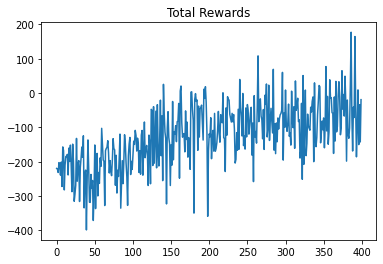

In [42]:
end = time.time()
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

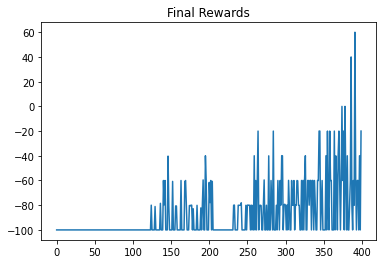

In [43]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()


訓練時間


In [44]:
print(f"total time is {end-start} sec")

total time is 808.405113697052 sec


## 測試

-226.48821687190065
length of actions is  273
117.60782515134393
length of actions is  1000
220.69751877093591
length of actions is  353
-35.09980539592594
length of actions is  258
-165.33359791425463
length of actions is  237


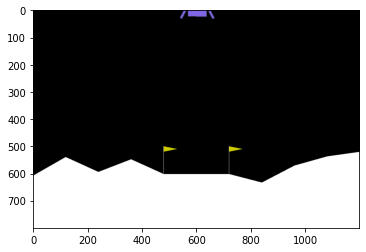

In [45]:
fix(env, seed)
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [46]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -17.72


Action list 的長相

In [47]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 

/Users/jane/anaconda3/envs/MLSpring/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Action 的分布


In [48]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{2: 728, 1: 256, 3: 777, 0: 360}


儲存 Model Testing的結果


In [49]:
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list)) 

/Users/jane/anaconda3/envs/MLSpring/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### 你要交到JudgeBoi的檔案94這個
儲存結果到本地端 (就是你的電腦裡拉 = = )


In [50]:
from google.colab import files
files.download(PATH)

ModuleNotFoundError: No module named 'google.colab'

# Server 測試
到時候下面會是我們Server上測試的環境，可以給大家看一下自己的表現如何

Your reward is : -226.49
Your reward is : 117.61
Your reward is : 220.70
Your reward is : -35.10
Your reward is : -165.33


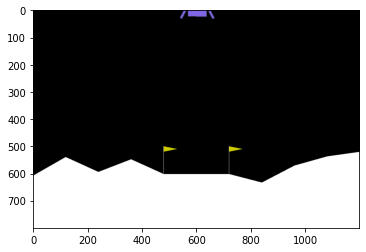

In [51]:
action_list = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)

agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

test_total_reward = []
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      # action, _ = agent1.sample(state)
      state, reward, done, _ = env.step(action)
      done_count += 1
      total_reward += reward
      if done:
        
        break
    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# 你的成績

In [52]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -17.72


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
